In [2]:
import matplotlib.pyplot as plt
import numpy as np

Helpful functions:

In [3]:
def create_circle_pattern(matrix, row, col, radius):
    n = matrix.shape[0]
    x, y = np.ogrid[:n, :n]
    dist = np.sqrt((x-row)**2 + (y-col)**2)
    matrix[dist <= radius] = 1
    return matrix

# Mathieu Equation

In [ ]:
# Class example:
def f(r,t):
    x = r[0]
    y = r[1]
    fx = x*y - x
    fy = y - x*y + np.sin(t)**2
    return np.array([fx,fy],float)

a = 0.0
b = 10.0
N = 1000
h = (b-a)/N

tpoints = np.arange(a,b,h)
r = np.zeros((N,2))
r[0] = [1.0, 1.0]

# To be completed in class: loop over time to solve for x and y, which
# will be stored in r[]
for i,t in enumerate(tpoints[1:],1):
    k1 = h * f(r[i-1], t)
    k2 = h * f(r[i-1] + 0.5*k1, t+0.5*h)
    k3 = h * f(r[i-1] + 0.5*k2, t+0.5*h)
    k4 = h * f(r[i-1]+k3, t+h)
    r[i] = r[i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6


plt.plot(tpoints, r[:,0], label='x')
plt.plot(tpoints, r[:,1], label='y')
plt.xlabel("t")
plt.ylabel("x,y")
plt.legend(loc='best')
plt.show()


# Electric field solutions:

In [13]:
# Constants
M = 100         # Grid squares on a side

freq = 100e6    # Drive frequency
Omega_Rf = 2 * np.pi *freq
A = 35           # Electric field amplitude
rod_radius = 25

coords_pos = [[rod_radius+1,rod_radius+1],[M-rod_radius-1,M-rod_radius-1]]
coords_neg = [[M-rod_radius-1,rod_radius+1],[rod_radius+1,M-rod_radius-1]]
pos_bit_pattern = np.zeros([M+1,M+1])
neg_bit_pattern = np.zeros([M+1,M+1])
for row,col in coords_pos:
    pos_bit_pattern = create_circle_pattern(pos_bit_pattern,row,col,rod_radius)
for row,col in coords_neg:
    neg_bit_pattern = create_circle_pattern(neg_bit_pattern,row,col,rod_radius)
# Now we have an easy way to device the negative and positive voltages


In [41]:
# Find the electrostatic field at the given time step.
# In time, we want to iterate over one period.
N = 10 # time steps
period = 1 / Omega_Rf
print(period)
time_step = np.linspace(start=0.0,stop=period,num=N)
a = 1e-3 # 1mm spacing

# We will call our two rods by their initial voltage pattern
negvoltage = -A * np.cos(time_step * Omega_Rf)
posvoltage = A * np.cos(time_step * Omega_Rf)
# Make a cumulative average, or a total matrix
phi_all = np.zeros((N,M+1,M+1),dtype=float)
it = 0
# Eventually will loop, for now let's take a look at one stable solution
for t in time_step:
    target = 1e-6
    epsilon_0 = 8.85e-12


    phi = np.zeros([M+1,M+1], float)
    rho = np.zeros([M+1,M+1], float)
    rho = rho + neg_bit_pattern * negvoltage[it] + pos_bit_pattern * posvoltage[it]
    phi = phi + neg_bit_pattern * negvoltage[it] + pos_bit_pattern * posvoltage[it]
    phiprime = np.zeros([M+1,M+1], float)

    # Main loop
    delta = 1.0
    iteration = 0
    while delta>target:
        # Calculate new values of the potential
        phiprime[0,:] = phi[0,:]
        phiprime[-1,:] = phi[-1,:]
        phiprime[:,0] = phi[:,0]
        phiprime[:,-1] = phi[:,-1]


        phiprime[1:M,1:M] = 0.25 * (phi[2:,1:M] + phi[:M-1,1:M] + phi[1:M,2:] + phi[1:M,:M-1]) + \
            (0.25 * a**2 / epsilon_0) * rho[1:M,1:M]    
                                        
        # Calculate maximum fractional difference from old values
        delta = np.abs(phi-phiprime)
        nonzero = phi > 0
        if nonzero.any():

            delta = np.max(delta[nonzero])
        else:
            delta = 1.0
       

        # Swap the two arrays around
        phi,phiprime = phiprime,phi
        iteration += 1
    phi_all[it] = phi
    print(it)
    it += 1




1.5915494309189535e-09


C:\Users\rmcgill9\AppData\Local\Temp\ipykernel_31600\2661739909.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


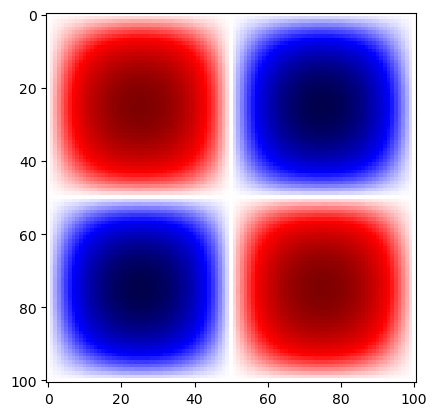

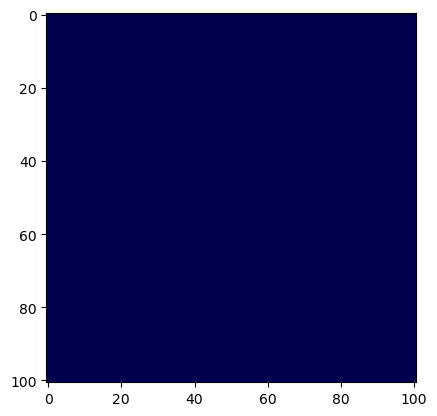

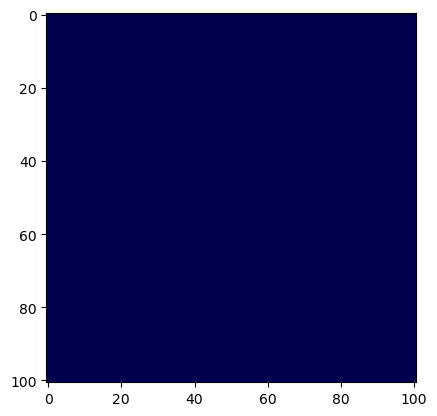

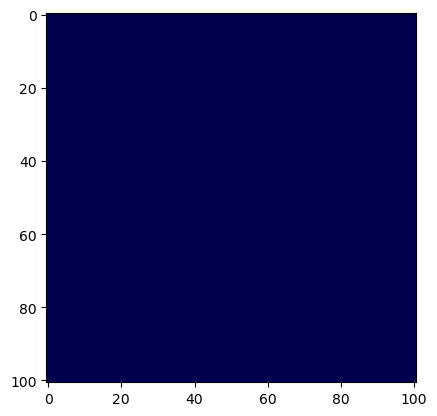

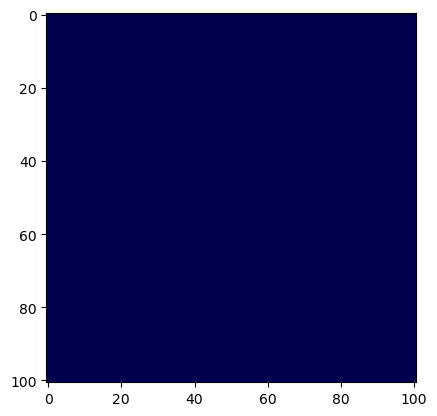

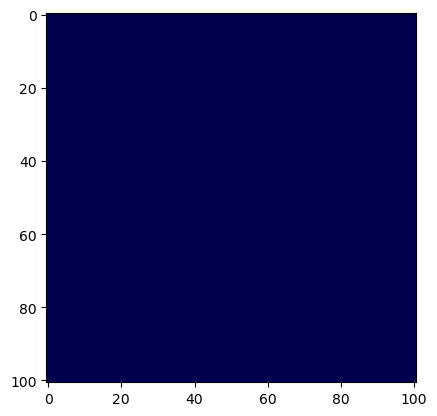

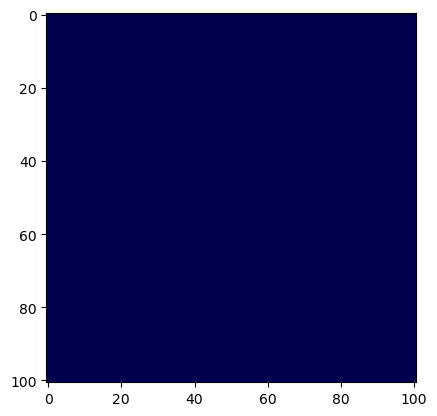

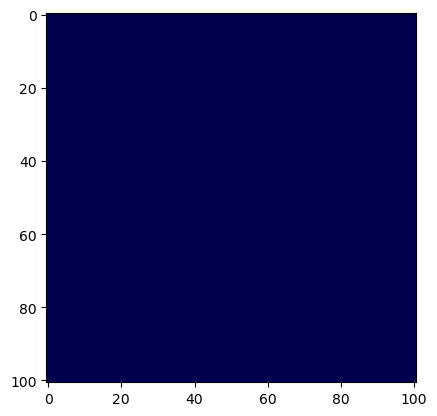

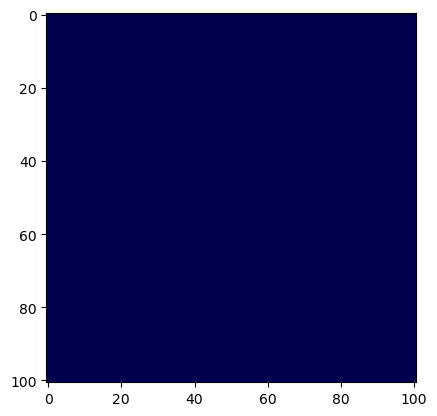

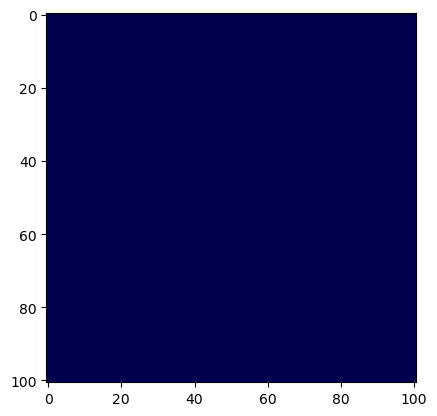

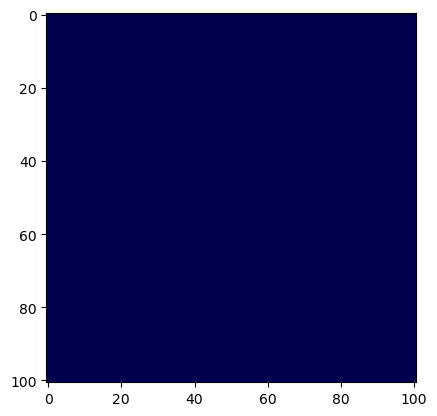

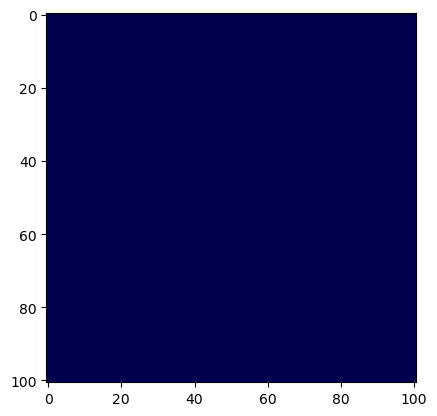

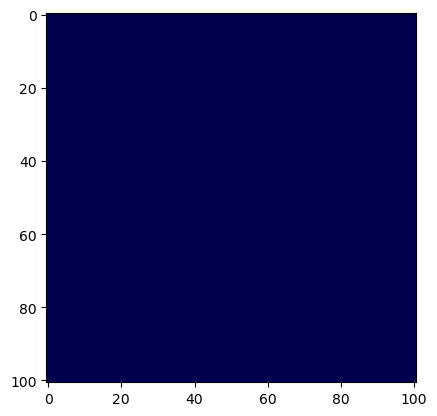

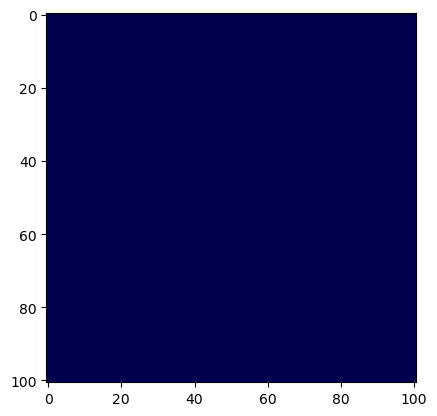

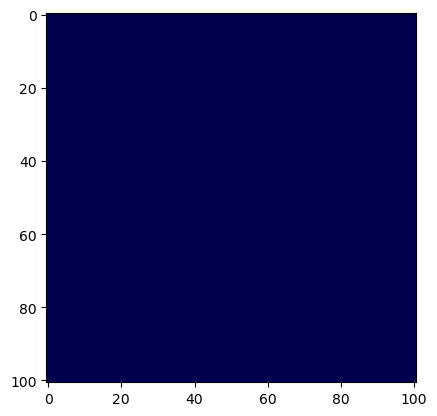

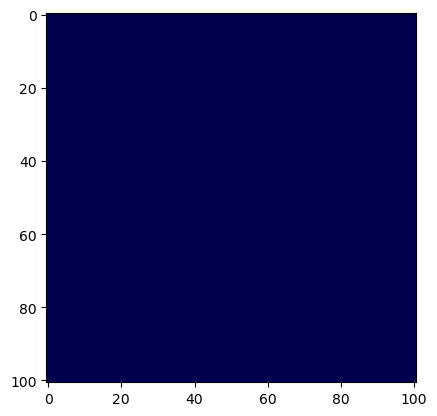

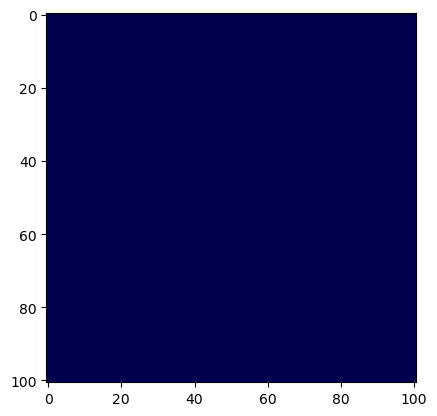

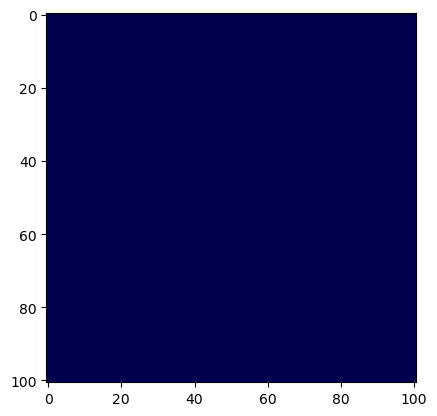

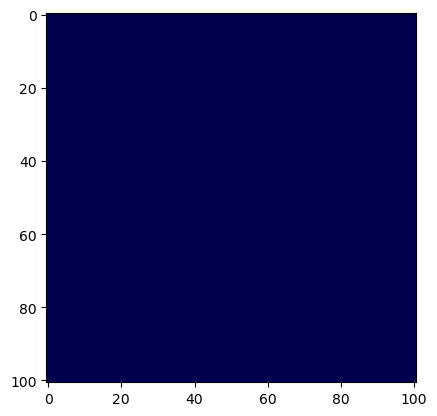

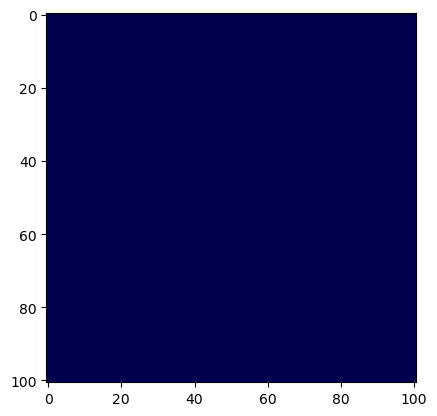

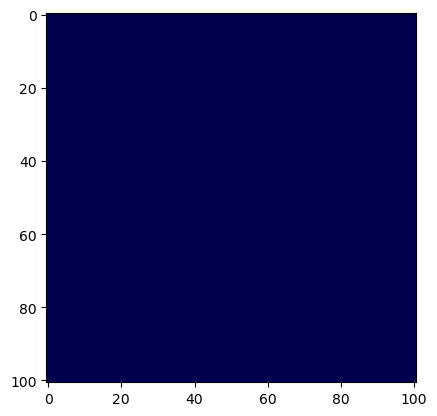

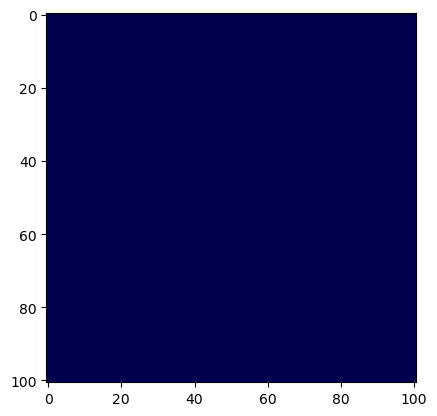

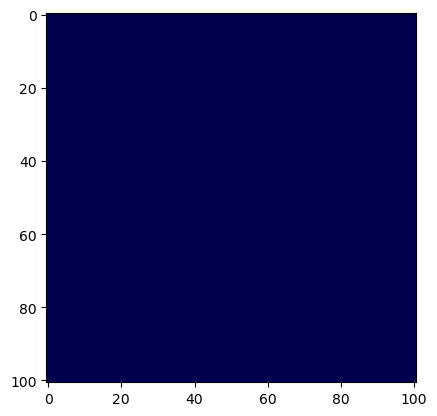

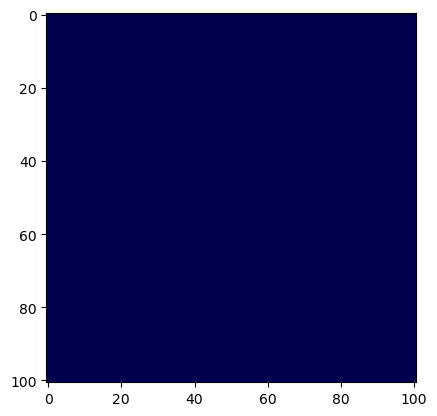

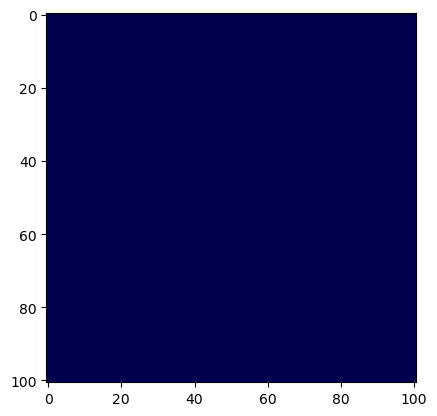

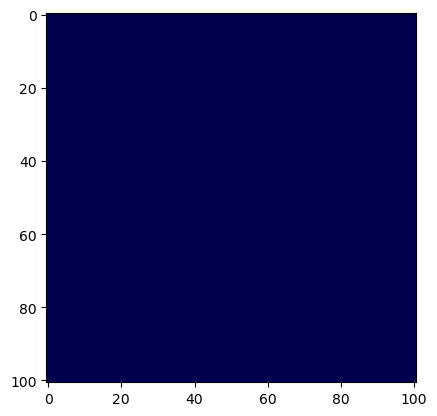

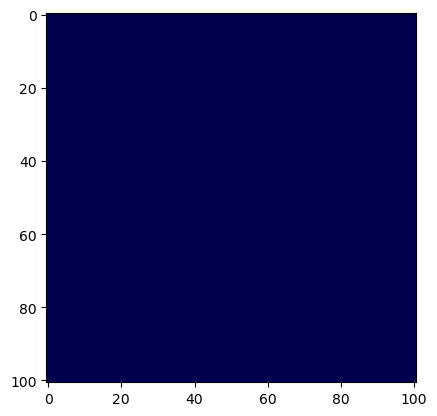

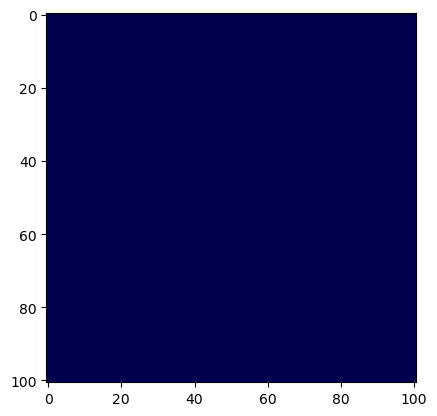

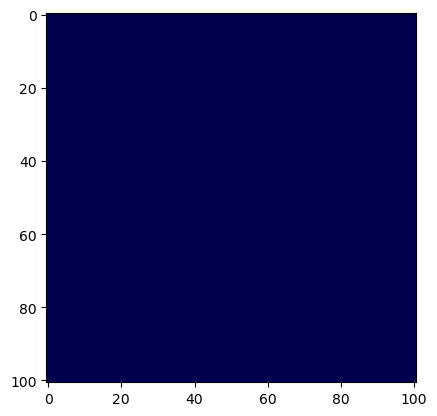

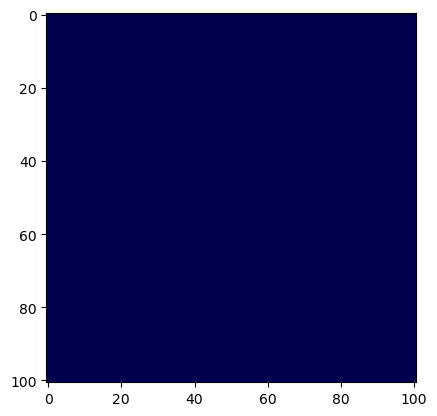

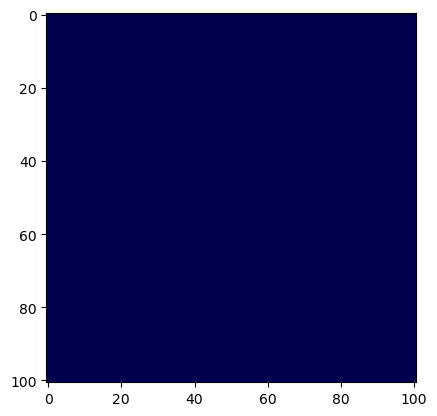

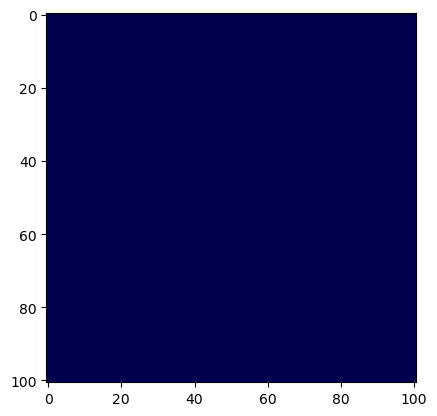

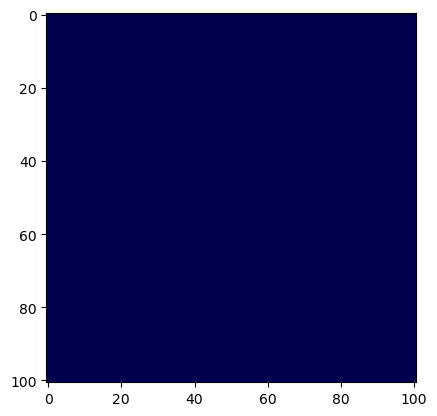

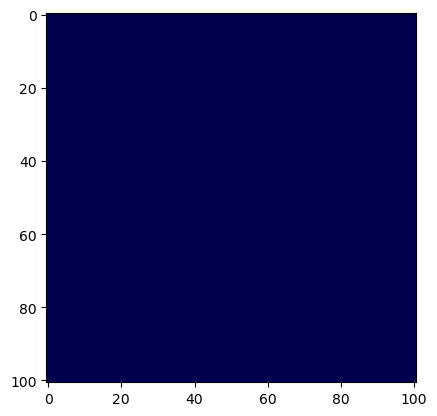

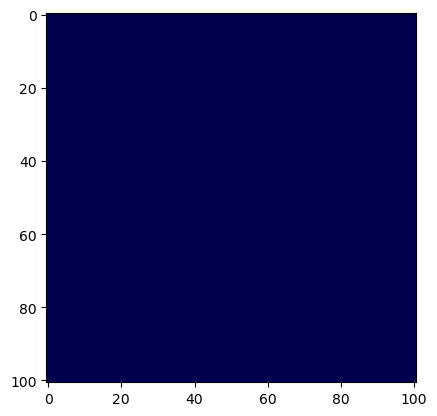

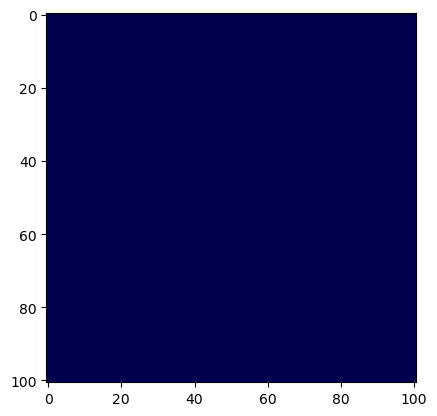

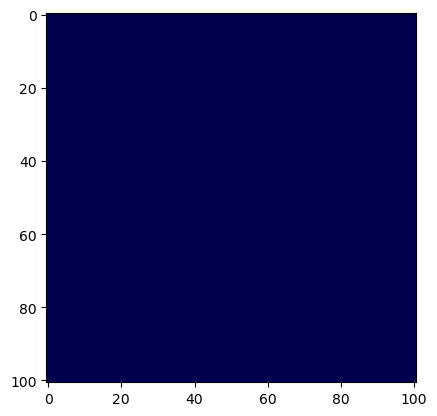

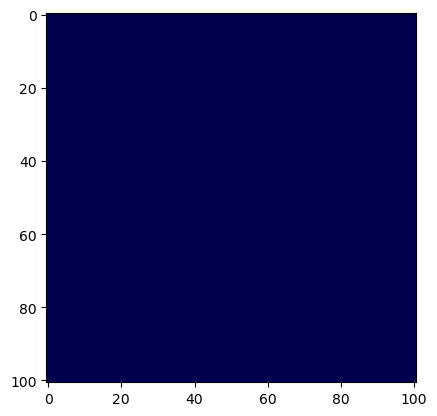

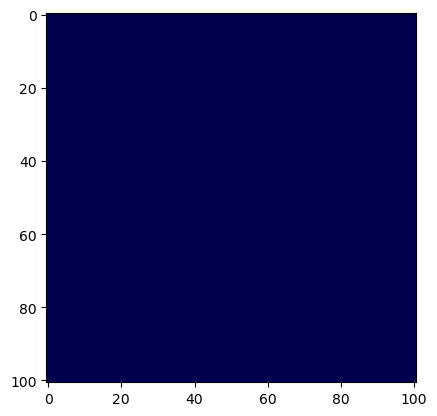

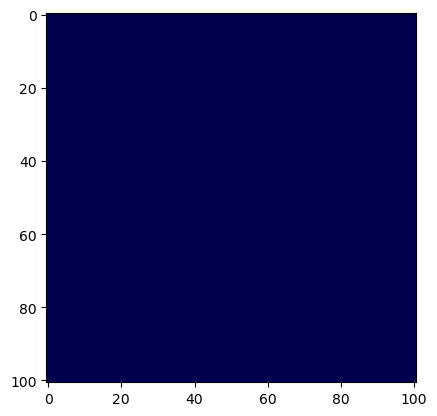

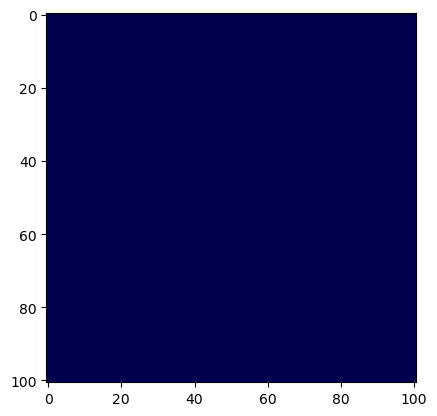

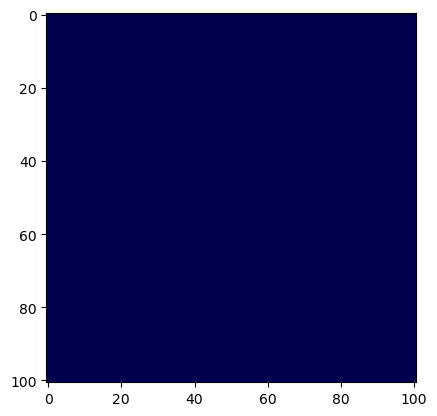

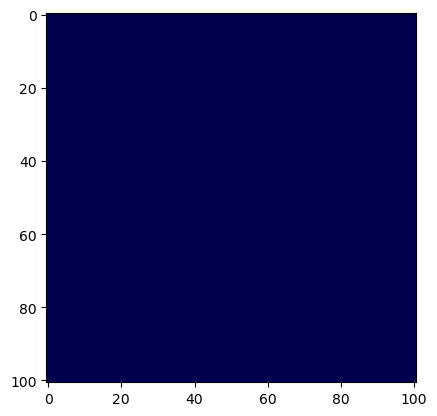

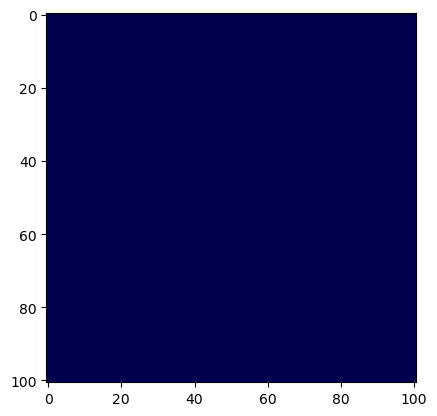

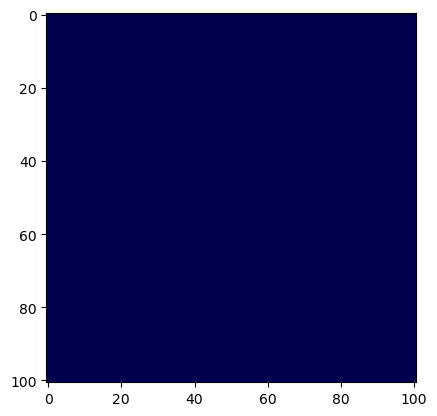

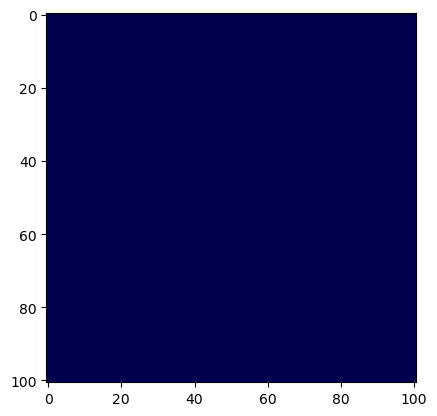

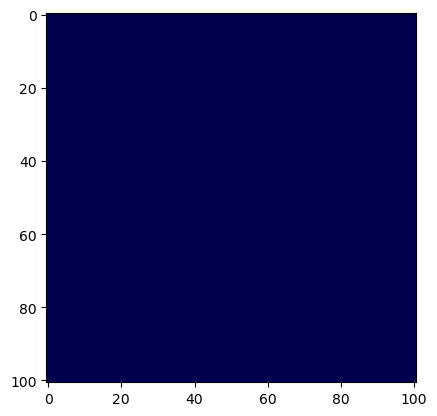

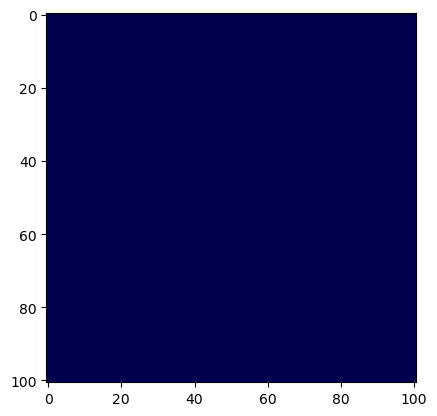

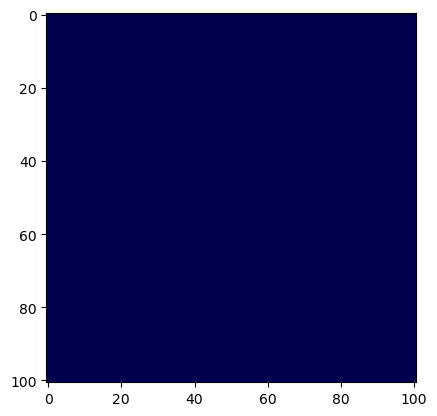

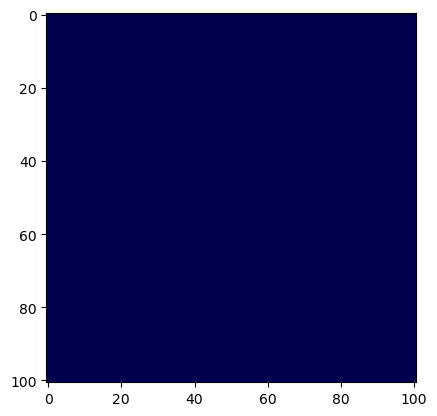

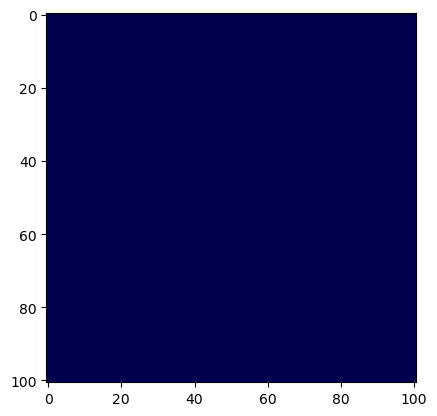

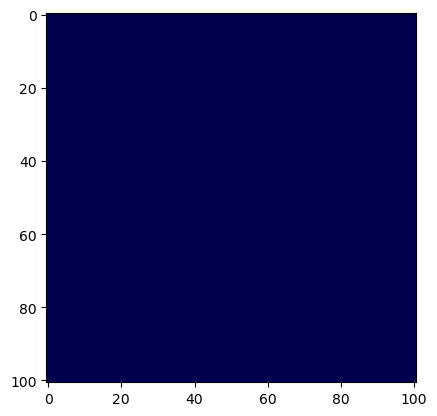

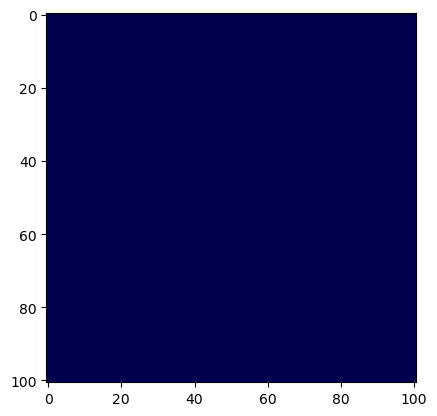

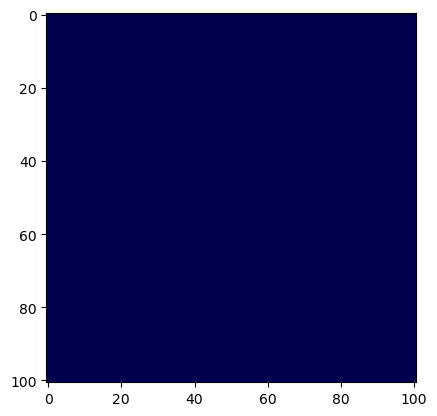

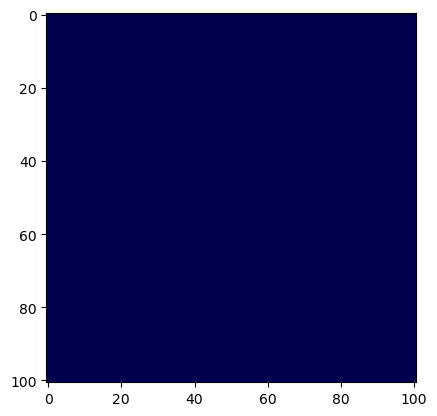

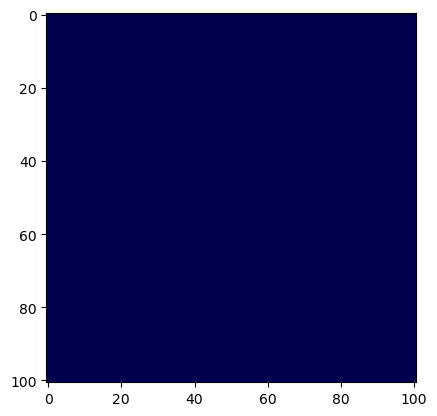

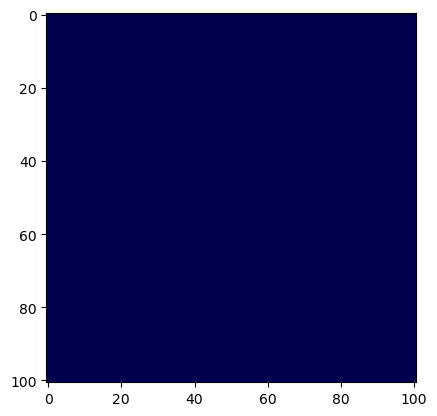

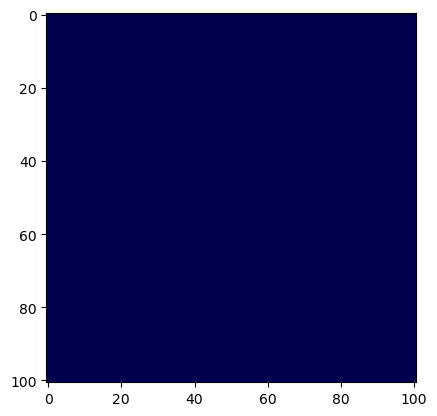

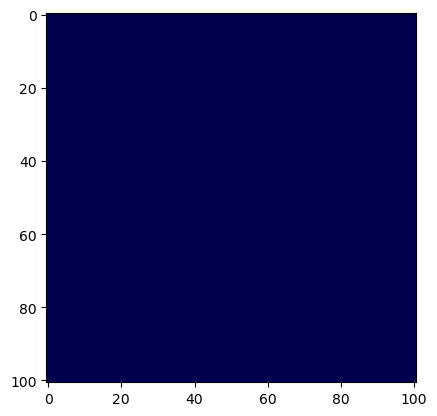

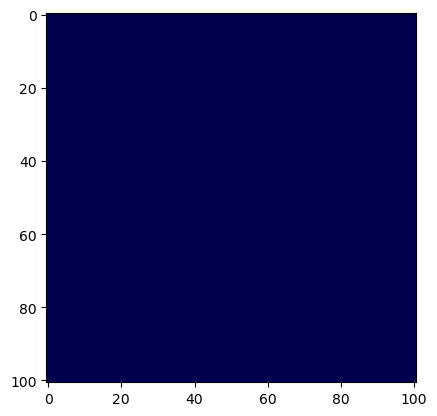

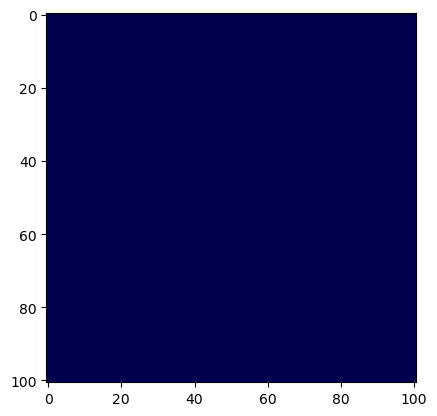

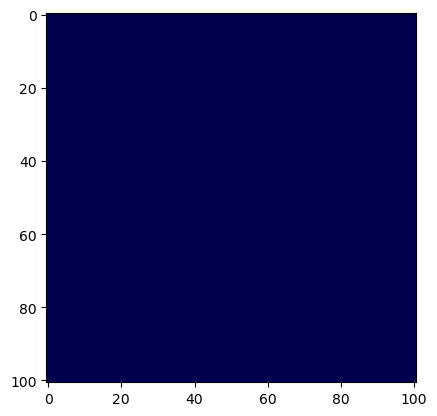

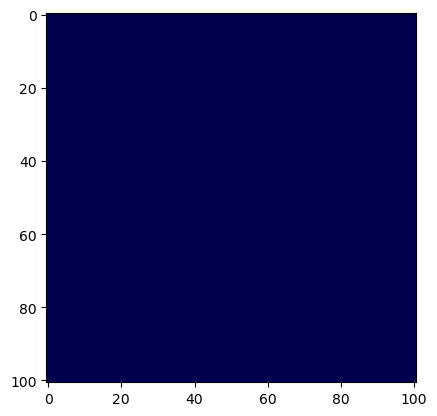

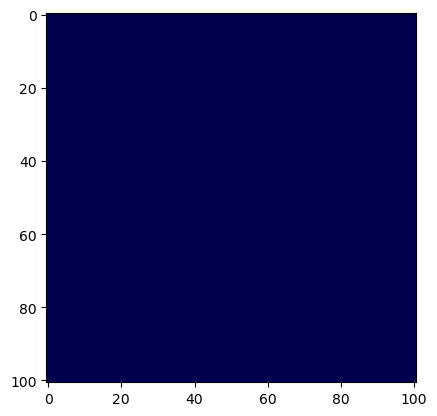

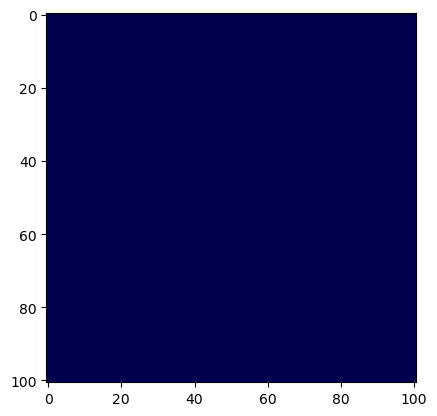

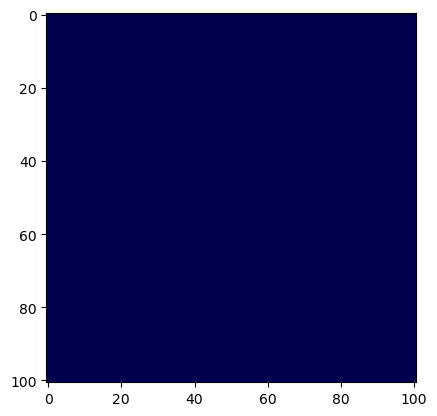

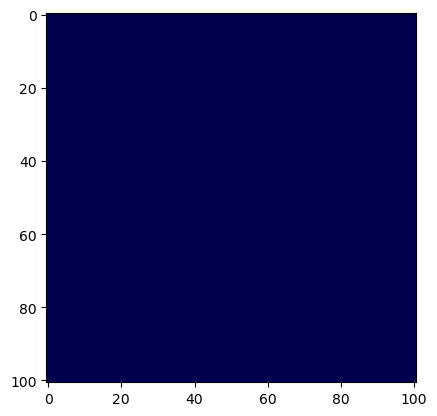

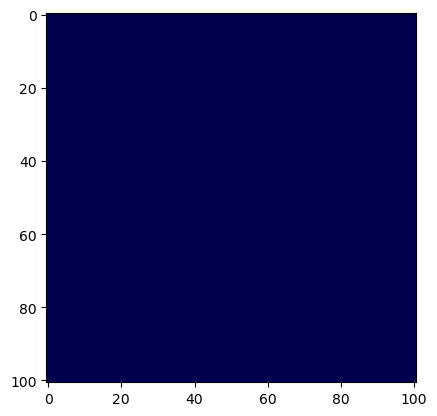

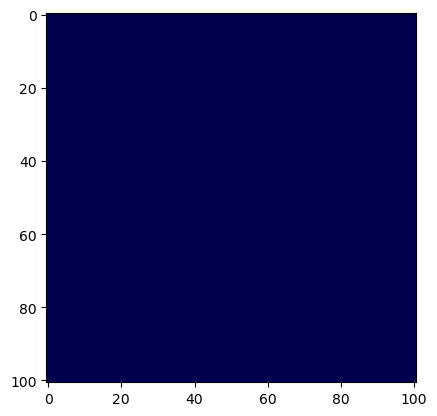

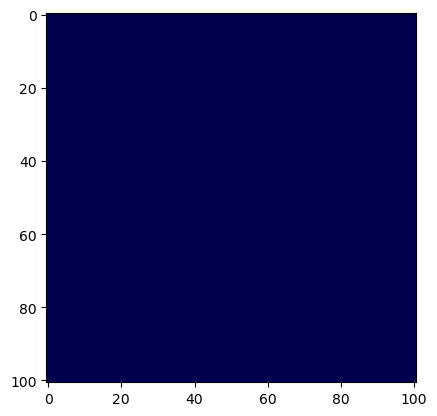

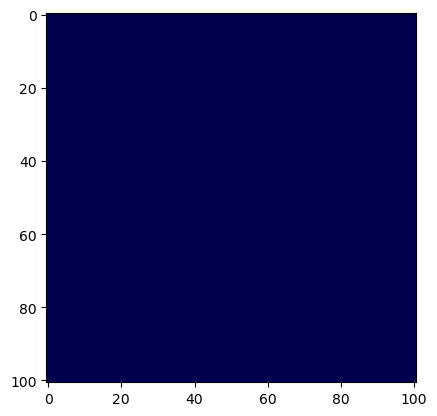

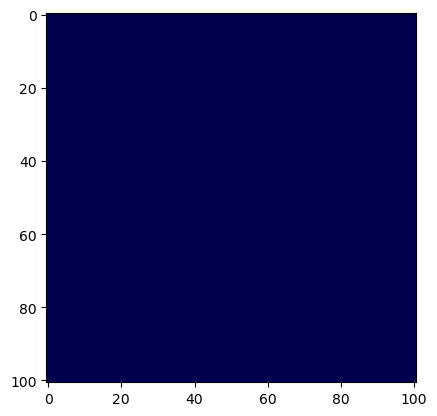

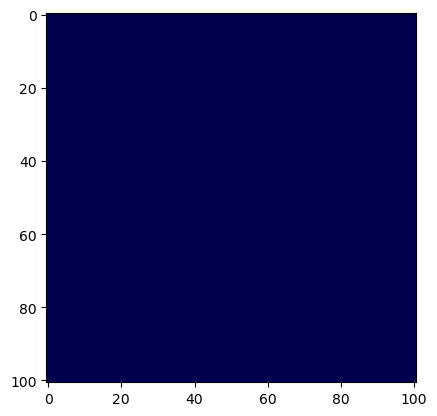

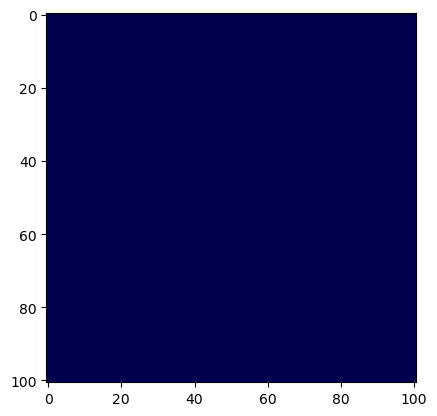

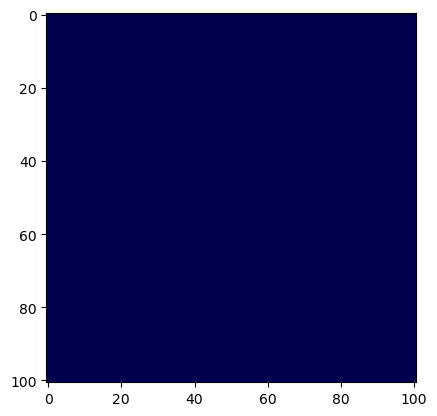

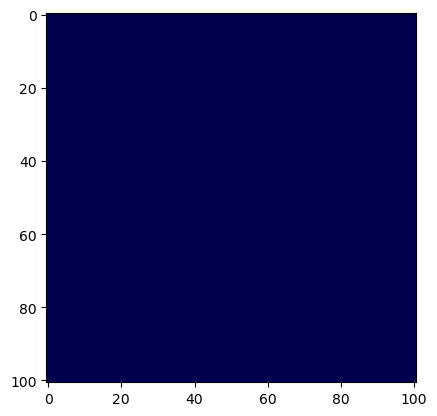

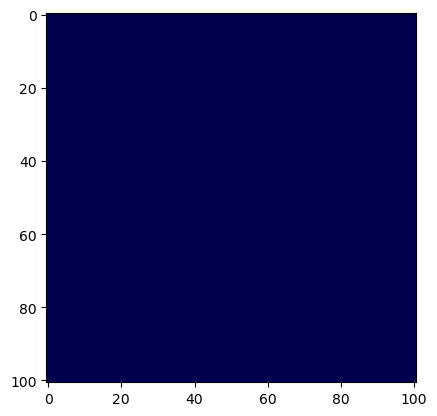

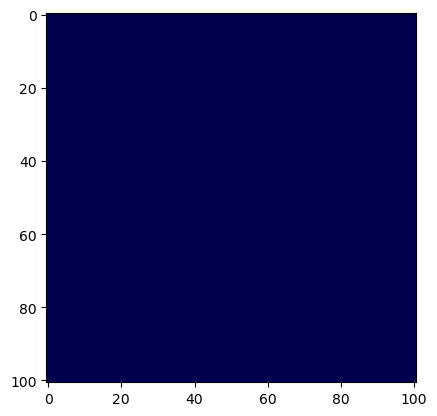

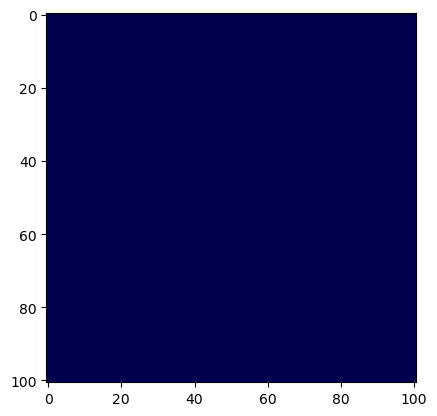

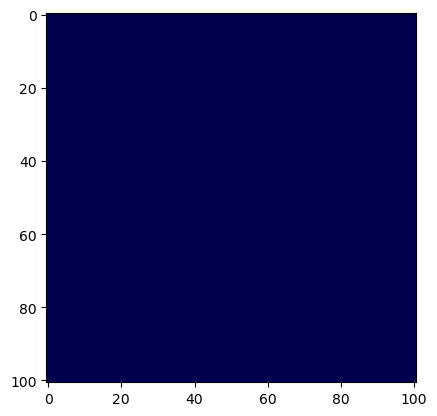

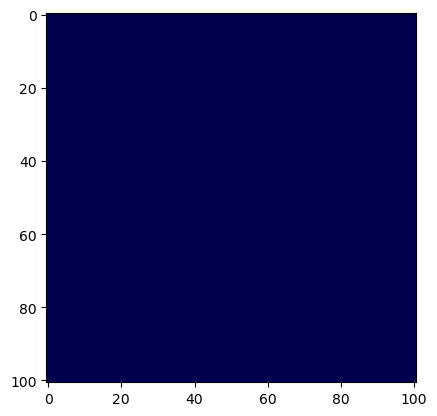

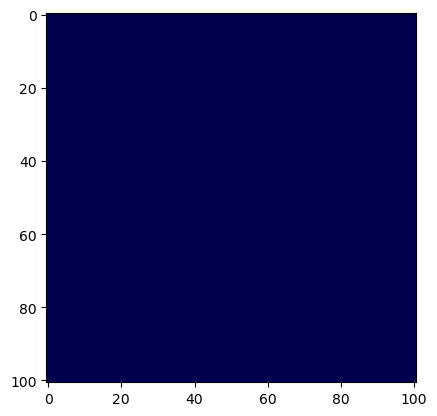

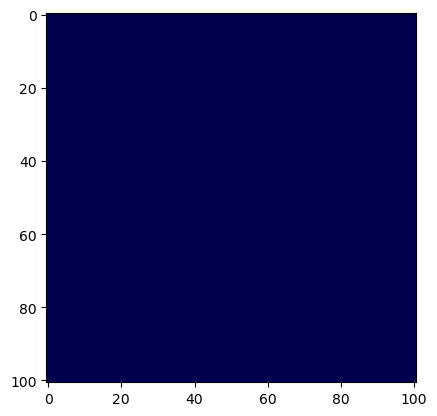

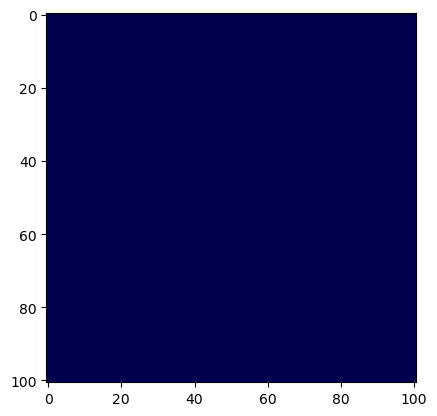

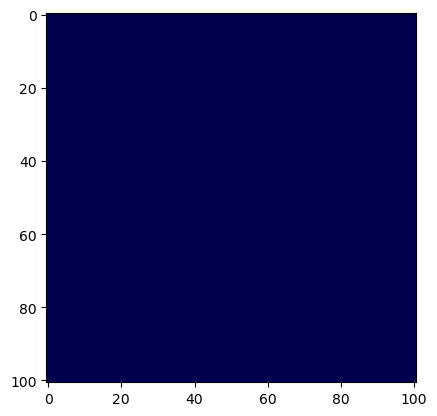

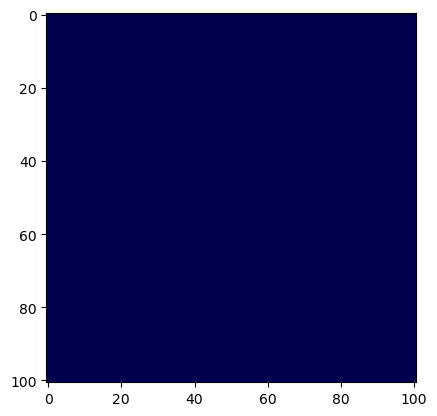

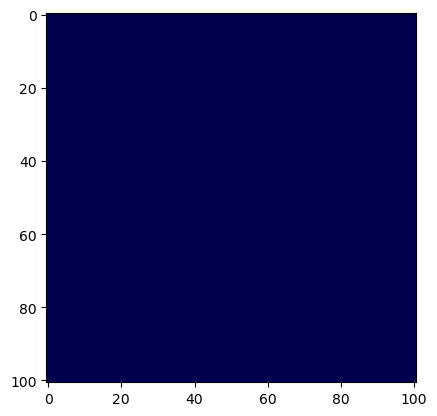

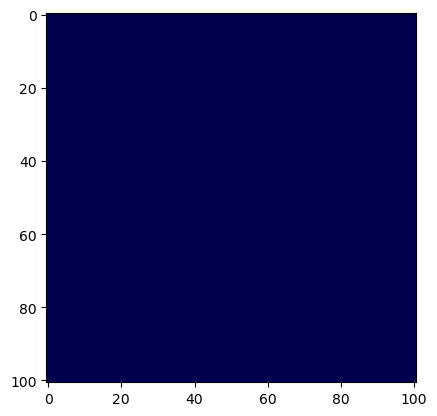

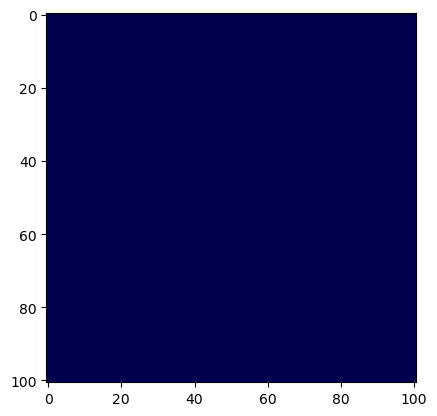

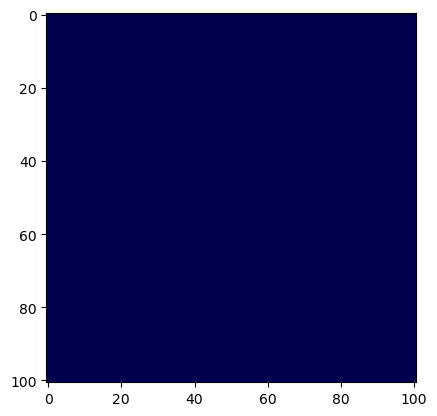

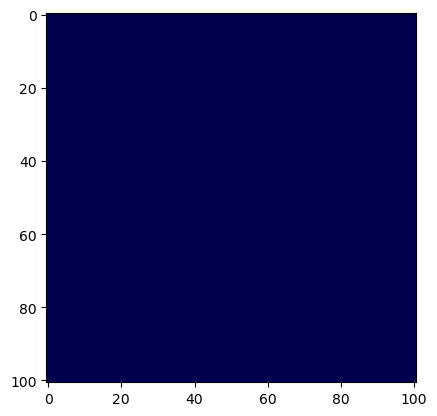

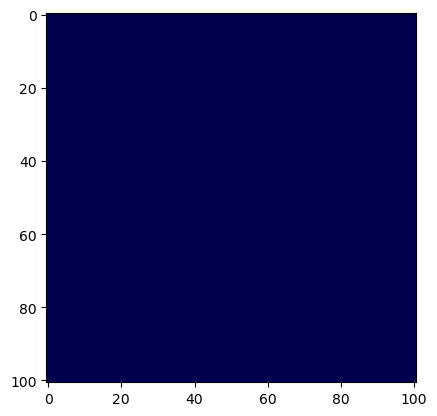

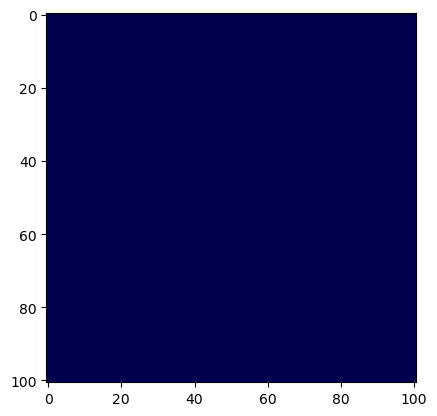

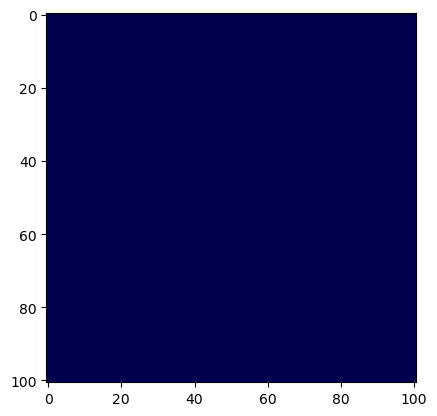

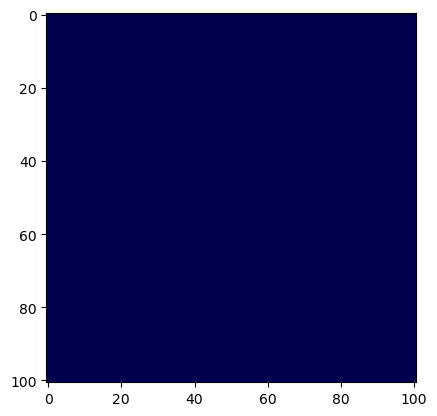

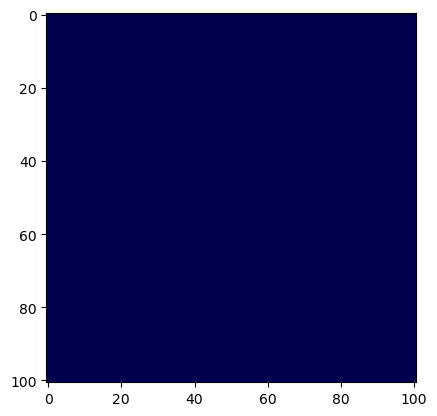

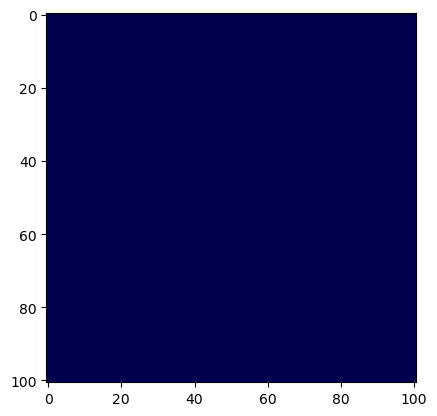

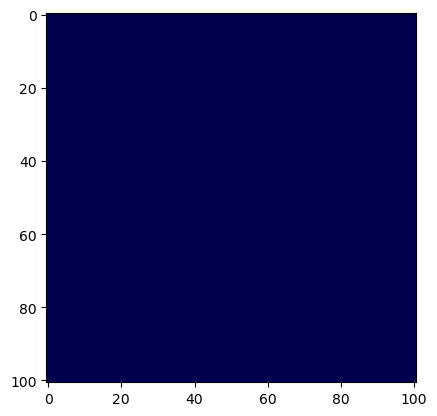

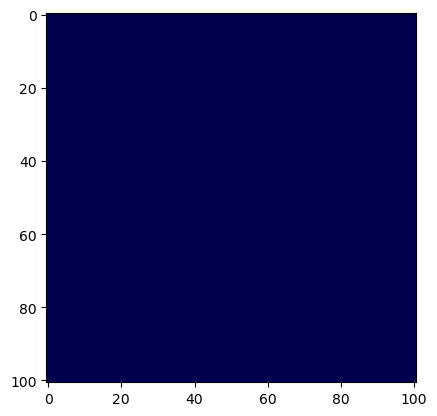

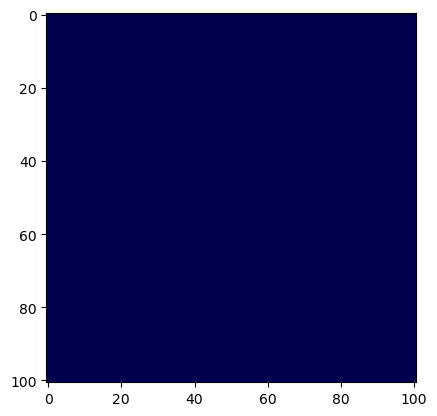

In [35]:
from PIL import Image, ImageDraw
from matplotlib import cm
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg


cmap = plt.get_cmap('seismic')

frames = []
for electric_field in phi_all:
    fig, ax = plt.subplots()
    im = ax.imshow(electric_field, cmap=cmap)
    # Add frame to list of frames
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    frame = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)
imageio.mimsave('efield.gif',frames,fps=10)